# SQuAD Data Analysis

This notebook wants to investigate the types of data in the dev set and the test set.

In [47]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import util
import matplotlib.pyplot as plt

from args import get_test_args
from collections import OrderedDict
from json import dumps
from models import BiDAF, QANet
from os.path import join
from ujson import load as json_load
from util import collate_fn, SQuAD

device, gpu_ids = util.get_available_devices()

In [2]:
word_emb_file = 'data/word_emb.json'
char_emb_file = 'data/char_emb.json'

word_vectors = util.torch_from_json(word_emb_file)
char_vectors = util.torch_from_json(char_emb_file)

In [3]:
# QANet model

qanet_model = QANet(char_vectors=char_vectors,
                      word_vectors=word_vectors,
                      hidden_size=128,
                      project=True,
                      use_char_cnn=False,
                      use_seq=True)

In [4]:
# BiDAF model

bidaf_model = BiDAF(char_vectors=char_vectors,
                      word_vectors=word_vectors,
                      hidden_size=100,
                      use_char_cnn=False)

In [5]:
dev_eval_file = 'data/dev_eval.json'
test_eval_file = 'data/test_eval.json'

In [6]:
# Dev
with open(dev_eval_file, 'r') as fh:
    dev_gold_dict = json_load(fh)

In [7]:
# Test
with open(test_eval_file, 'r') as fh:
    test_gold_dict = json_load(fh)

In [8]:
q_types = ['how many', 'how', 'what', 'why', 'which', 'who', 'where', 'when', 'other']

In [9]:
def get_question_type_dist(gold_dict):
    totals = {}
    for q_type in q_types:
        totals[q_type] = 0
    
    total_questions = len(gold_dict)
    print(f'Length of the set = {total_questions}')
        
    for key in gold_dict:
        for q_type in q_types:
            if q_type == 'other' or q_type in gold_dict[key]['question'].lower():
                totals[q_type] += 1
                break
    
    # Print Total
    print('\n'.join(q_types))
    print('\t&\t'.join(['', 'Dev (\%)', 'Test (\%)', 'Dev (\#)', 'Test (\#)']))
    for q_type in q_types:
#         print(f'{totals[q_type]}, pct = {totals[q_type] * 100. / total_questions}%')
        print(f'&\t{round(totals[q_type] * 100. / total_questions, 2)}\%\t&\t{totals[q_type]}')



In [10]:
# Dev
get_question_type_dist(dev_gold_dict)

Length of the set = 6078
how many
how
what
why
which
who
where
when
other
	&	Dev (\%)	&	Test (\%)	&	Dev (\#)	&	Test (\#)
&	4.48\%	&	272
&	5.48\%	&	333
&	61.06\%	&	3711
&	1.5\%	&	91
&	3.97\%	&	241
&	11.39\%	&	692
&	4.11\%	&	250
&	7.06\%	&	429
&	0.97\%	&	59


In [11]:
# Test
get_question_type_dist(test_gold_dict)

Length of the set = 5915
how many
how
what
why
which
who
where
when
other
	&	Dev (\%)	&	Test (\%)	&	Dev (\#)	&	Test (\#)
&	5.95\%	&	352
&	6.81\%	&	403
&	63.79\%	&	3773
&	1.78\%	&	105
&	4.63\%	&	274
&	7.37\%	&	436
&	3.85\%	&	228
&	4.97\%	&	294
&	0.85\%	&	50


In [12]:
record_file = 'data/dev.npz'
dataset = SQuAD(record_file, True)
data_loader = data.DataLoader(dataset,
                              batch_size=1,
                              shuffle=False,
                              num_workers=0,
                              collate_fn=collate_fn)

In [13]:
# Load BiDAF Model
bidaf_load_path = 'save/train/ensemble/bidaf/nocnn/hs100-01/best.pth.tar'
bidaf_model = nn.DataParallel(bidaf_model, gpu_ids)
bidaf_model = util.load_model(bidaf_model, bidaf_load_path, gpu_ids, return_step=False)
bidaf_model = bidaf_model.to(device)
bidaf_model.eval()

DataParallel(
  (module): BiDAF(
    (emb): Embedding(
      (char_embed): Embedding(1376, 200, padding_idx=0)
      (word_embed): Embedding(88430, 300)
      (proj): Linear(in_features=3500, out_features=100, bias=False)
      (hwy): HighwayEncoder(
        (transforms): ModuleList(
          (0): Linear(in_features=100, out_features=100, bias=True)
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
        (gates): ModuleList(
          (0): Linear(in_features=100, out_features=100, bias=True)
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
      )
    )
    (enc): RNNEncoder(
      (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
    )
    (att): BiDAFAttention()
    (self_att): SelfAttention(
      (pe): PositionalEncoding(
        (dropout): Dropout(p=0, inplace=False)
      )
      (multihead_att): MultiHeadAttention(
        (key): Linear(in_features=200, out_features=200, bias=True)
        (query): Linear(in_f

In [14]:
# Load QANet Model
qanet_load_path = 'save/train/ensemble/nocnn/qanet-base-stochastic-depth-03/best.pth.tar'
qanet_model = nn.DataParallel(qanet_model, gpu_ids)
qanet_model = util.load_model(qanet_model, qanet_load_path, gpu_ids, return_step=False)
qanet_model = qanet_model.to(device)
qanet_model.eval()

DataParallel(
  (module): QANet(
    (emb): Embedding(
      (char_embed): Embedding(1376, 200, padding_idx=0)
      (word_embed): Sequential(
        (0): Embedding(88430, 300)
        (1): Dropout(p=0.0, inplace=False)
      )
      (proj): Conv1dLinear(
        (conv): Conv1d(3500, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
      (hwy): HighwayEncoder(
        (transforms): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
        (gates): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
      )
    )
    (enc): EncoderBlock(
      (pe): PositionalEncoding(
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (conv): Sequential(
        (0): ResidualBlock(
          (module): DepthWiseSeparableConv1d(
            (depth_conv): Conv1d(128, 128, ker

In [15]:
investigate_question1 = 'How did peace start?'
investigate_question2 = 'How much British military was in North America at start of War?'

In [249]:
def evaluate(model, investigate_question):
    for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
        # Setup for forward
        cw_idxs = cw_idxs.to(device)
        cc_idxs = cc_idxs.to(device)
        qw_idxs = qw_idxs.to(device)
        qc_idxs = qc_idxs.to(device)
        batch_size = cw_idxs.size(0)

        qid = ids[0].item()
        context = dev_gold_dict[str(qid)]["context"]
        question = dev_gold_dict[str(qid)]["question"]
        answers = dev_gold_dict[str(qid)]["answers"]
        spans = dev_gold_dict[str(qid)]["spans"]
        uuid = dev_gold_dict[str(qid)]["uuid"]

        if question != investigate_question:
            continue
        
        print(f'context_len {len(context)}, cw_idxs.shape {cw_idxs.shape}')

        # Forward
        log_p1, log_p2 = model(cw_idxs, cc_idxs, qw_idxs, qc_idxs)
        y1, y2 = y1.to(device), y2.to(device)
        loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)

        # Get F1 and EM scores
        p1, p2 = log_p1.exp(), log_p2.exp()
        starts, ends = util.discretize(p1, p2, 15, True)
        idx2pred, uuid2pred = util.convert_tokens(dev_gold_dict,
                                                  ids.tolist(),
                                                  starts.tolist(),
                                                  ends.tolist(),
                                                  True)

        return context, question, idx2pred[str(qid)], answers

In [164]:
# Plot attention
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def show_attn(input_sentence, output_words, attentions, save_file_path):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(40, 20), dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax,fraction=0.046, pad=0.04,location="bottom")

    # Set up axes
    ax.set_xticklabels(['', '<START>'] + input_sentence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels(['', '<START>'] + output_words +
                       ['<EOS>'])

#     # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig(save_file_path, facecolor='white', edgecolor='none')
    plt.show()

In [225]:
context, question, prediction = evaluate(bidaf_model, investigate_question1)

print(f'question: {question}')
print(f'answer: {prediction}')

context_len 548, cw_idxs.shape torch.Size([1, 104])
c_len=104, q_len=6
{'5314': 'a dispute over control of the confluence of the Allegheny and Monongahela rivers'}
question: How did peace start?
answer: a dispute over control of the confluence of the Allegheny and Monongahela rivers


In [226]:
bidaf_c2q_attention = torch.load('c2q.pt')[0, :]
bidaf_q2c_attention = torch.load('q2c.pt')[0, :]

print(f'{bidaf_c2q_attention.shape}, {bidaf_q2c_attention.shape}')

torch.Size([104, 6]), torch.Size([104, 6])


In [227]:
import spacy

nlp = spacy.blank("en")
def word_tokenize(sent):
    doc = nlp(sent)
    return [token.text for token in doc]

In [228]:
context_words = word_tokenize(context)
question_words = word_tokenize(question)
len(question_words), len(context_words)

(5, 101)

C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1404574188.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '<START>'] + input_sentence +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1404574188.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + output_words +


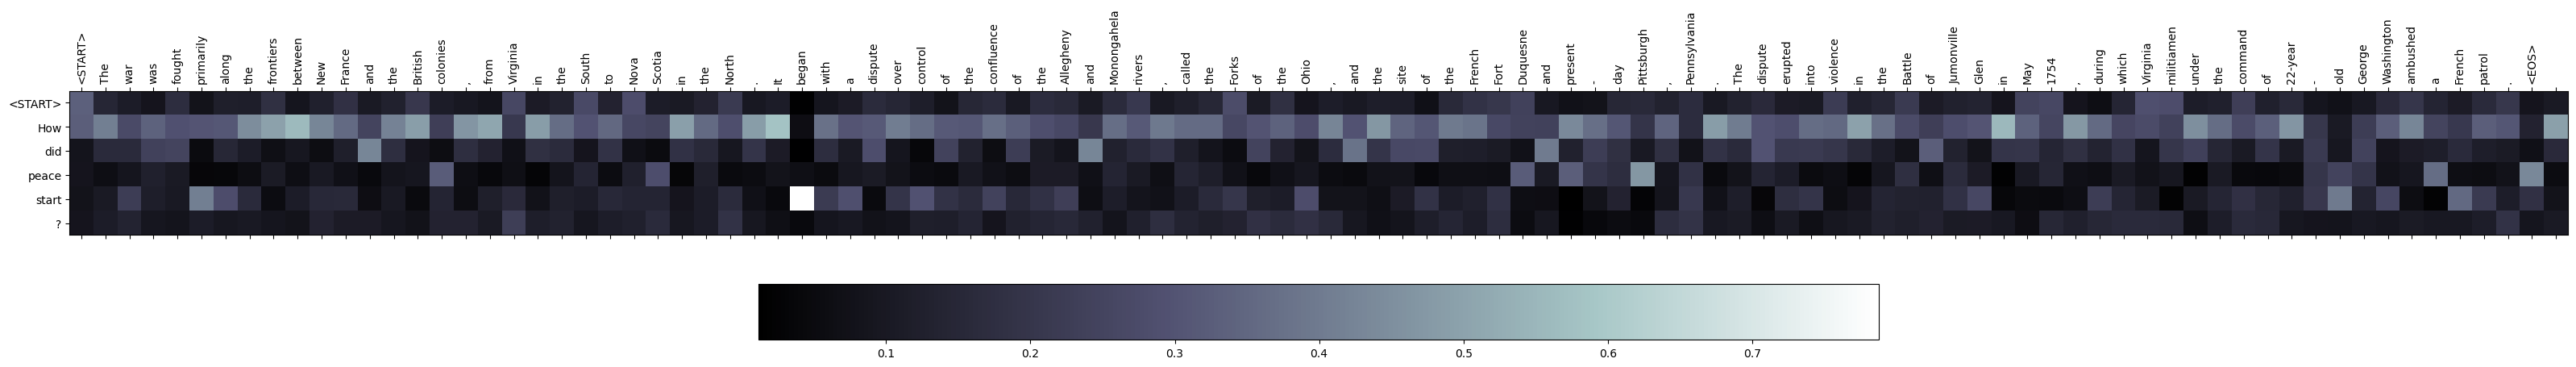

In [229]:
save_file_path = 'bidaf_attention_q1'
show_attn(context_words, question_words, bidaf_c2q_attention.T.cpu().detach(), save_file_path)

In [230]:
evaluate(qanet_model, investigate_question1)

context_len 548, cw_idxs.shape torch.Size([1, 104])
c_len=104, q_len=6
{'5314': 'with a dispute over control of the confluence of the Allegheny and Monongahela rivers'}


('The war was fought primarily along the frontiers between New France and the British colonies, from Virginia in the South to Nova Scotia in the North. It began with a dispute over control of the confluence of the Allegheny and Monongahela rivers, called the Forks of the Ohio, and the site of the French Fort Duquesne and present-day Pittsburgh, Pennsylvania. The dispute erupted into violence in the Battle of Jumonville Glen in May 1754, during which Virginia militiamen under the command of 22-year-old George Washington ambushed a French patrol.',
 'How did peace start?',
 'with a dispute over control of the confluence of the Allegheny and Monongahela rivers')

In [231]:
qanet_c2q_attention = torch.load('c2q.pt')[0, :]
qanet_q2c_attention = torch.load('q2c.pt')[0, :]

print(f'{qanet_c2q_attention.shape}, {qanet_q2c_attention.shape}')

torch.Size([104, 6]), torch.Size([104, 6])


In [232]:
context_words = word_tokenize(context)
question_words = word_tokenize(question)
len(question_words), len(context_words)

(5, 101)

In [302]:
def show_attention(bidaf_c2q_attention, qanet_c2q_attention, save_file_path, c2q=True):
    # Set up figure with colorbar
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8), dpi=100)
    ax = axes.flat[0]
    cax = ax.matshow(bidaf_c2q_attention.T.cpu().detach().numpy(), cmap='bone', aspect='auto')

    # Set up axes
    ax.set_yticklabels(['', '<START>'] + question_words +
                       ['<EOS>'])
    ax.set_xticklabels(['', '<START>'] + context_words +
                       ['<EOS>'], rotation=90)

    #     # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    attn_type = 'C2Q' if c2q else 'Q2C'
    ax.title.set_text(f'BiDAF {attn_type} Attention')

    ax = axes.flat[1]
    cax = ax.matshow(qanet_c2q_attention.T.cpu().detach().numpy(), cmap='bone', aspect='auto') 
#     fig.colorbar(cax)
    fig.colorbar(cax,fraction=0.046, pad=0.04,location="bottom")

    # Set up axes
    ax.set_yticklabels(['', '<START>'] + question_words +
                       ['<EOS>'])

        
    #     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.title.set_text(f'QANet {attn_type} Attention')

    plt.savefig(save_file_path, facecolor='white', edgecolor='none')
    plt.show()

C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\2885343987.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\2885343987.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '<START>'] + context_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\2885343987.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +


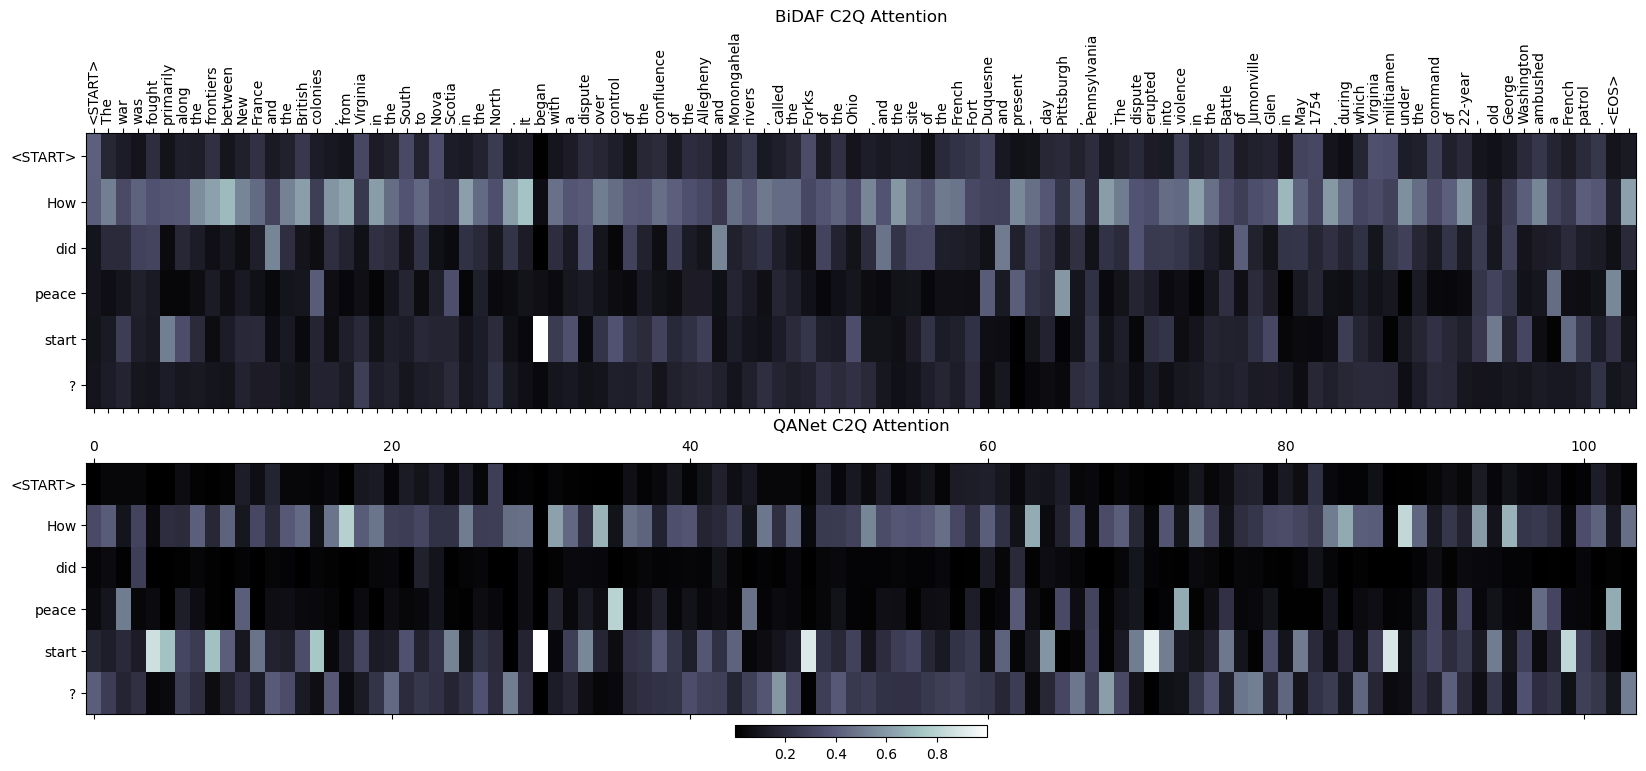

In [240]:
save_file_path = 'attention_q1'
show_attention(bidaf_c2q_attention, qanet_c2q_attention, save_file_path)

In [241]:
context, question, prediction = evaluate(bidaf_model, investigate_question2)

print(f'question: {question}')
print(f'answer: {prediction}')

context_len 508, cw_idxs.shape torch.Size([1, 92])
c_len=92, q_len=14
{'5396': 'no French regular army troops were stationed in North America, and few British troops'}
question: How much British military was in North America at start of War?
answer: no French regular army troops were stationed in North America, and few British troops


In [242]:
bidaf_c2q_attention = torch.load('c2q.pt')[0, :]
bidaf_q2c_attention = torch.load('q2c.pt')[0, :]

In [243]:
context_words = word_tokenize(context)
question_words = word_tokenize(question)

In [244]:
context, question, prediction = evaluate(qanet_model, investigate_question2)

print(f'question: {question}')
print(f'answer: {prediction}')

context_len 508, cw_idxs.shape torch.Size([1, 92])
c_len=92, q_len=14
{'5396': 'few'}
question: How much British military was in North America at start of War?
answer: few


In [245]:
qanet_c2q_attention = torch.load('c2q.pt')[0, :]
qanet_q2c_attention = torch.load('q2c.pt')[0, :]

C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\2885343987.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\2885343987.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '<START>'] + context_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\2885343987.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +


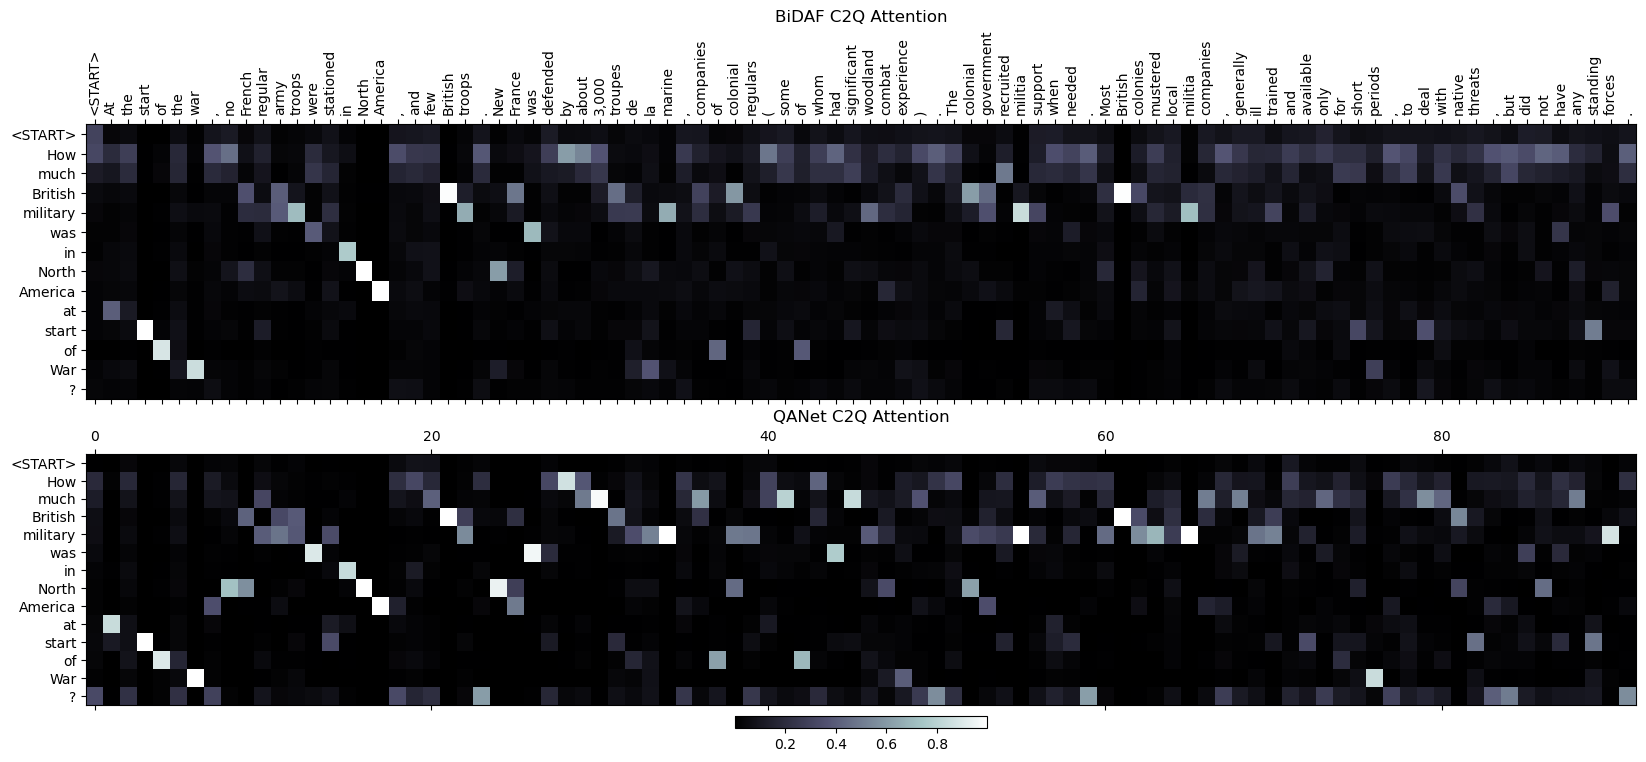

In [246]:
save_file_path = 'attention_q2'
show_attention(bidaf_c2q_attention, qanet_c2q_attention, save_file_path)

In [331]:
investigate_question3 = 'Why did French feel they had right to Ohio claim?'

In [332]:
context, question, prediction, answers = evaluate(bidaf_model, investigate_question3)

print(f'question: {question}')
print(f'prediction: {prediction}')
print(f'answers: {answers}')

context_len 600, cw_idxs.shape torch.Size([1, 120])
c_len=120, q_len=12
question: Why did French feel they had right to Ohio claim?
prediction: France's claim to the region was superior to that of the British
answers: ["France's claim to the region was superior to that of the British", 'Sieur de La Salle had explored the Ohio Country nearly a century earlier', 'René-Robert Cavelier, Sieur de La Salle had explored the Ohio Country nearly a century earlier.', 'René-Robert Cavelier, Sieur de La Salle had explored the Ohio Country', 'René-Robert Cavelier, Sieur de La Salle had explored the Ohio Country nearly a century earlier']


In [333]:
bidaf_c2q_attention = torch.load('c2q.pt')[0, :]
bidaf_q2c_attention = torch.load('q2c.pt')[0, :]
context_words = word_tokenize(context)
question_words = word_tokenize(question)

In [334]:
context, question, prediction, answers = evaluate(qanet_model, investigate_question3)

print(f'question: {question}')
print(f'prediction: {prediction}')
print(f'answers: {answers}')

context_len 600, cw_idxs.shape torch.Size([1, 120])
c_len=120, q_len=12
question: Why did French feel they had right to Ohio claim?
prediction: 
answers: ["France's claim to the region was superior to that of the British", 'Sieur de La Salle had explored the Ohio Country nearly a century earlier', 'René-Robert Cavelier, Sieur de La Salle had explored the Ohio Country nearly a century earlier.', 'René-Robert Cavelier, Sieur de La Salle had explored the Ohio Country', 'René-Robert Cavelier, Sieur de La Salle had explored the Ohio Country nearly a century earlier']


In [335]:
qanet_c2q_attention = torch.load('c2q.pt')[0, :]
qanet_q2c_attention = torch.load('q2c.pt')[0, :]

C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1629995797.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1629995797.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '<START>'] + context_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1629995797.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +


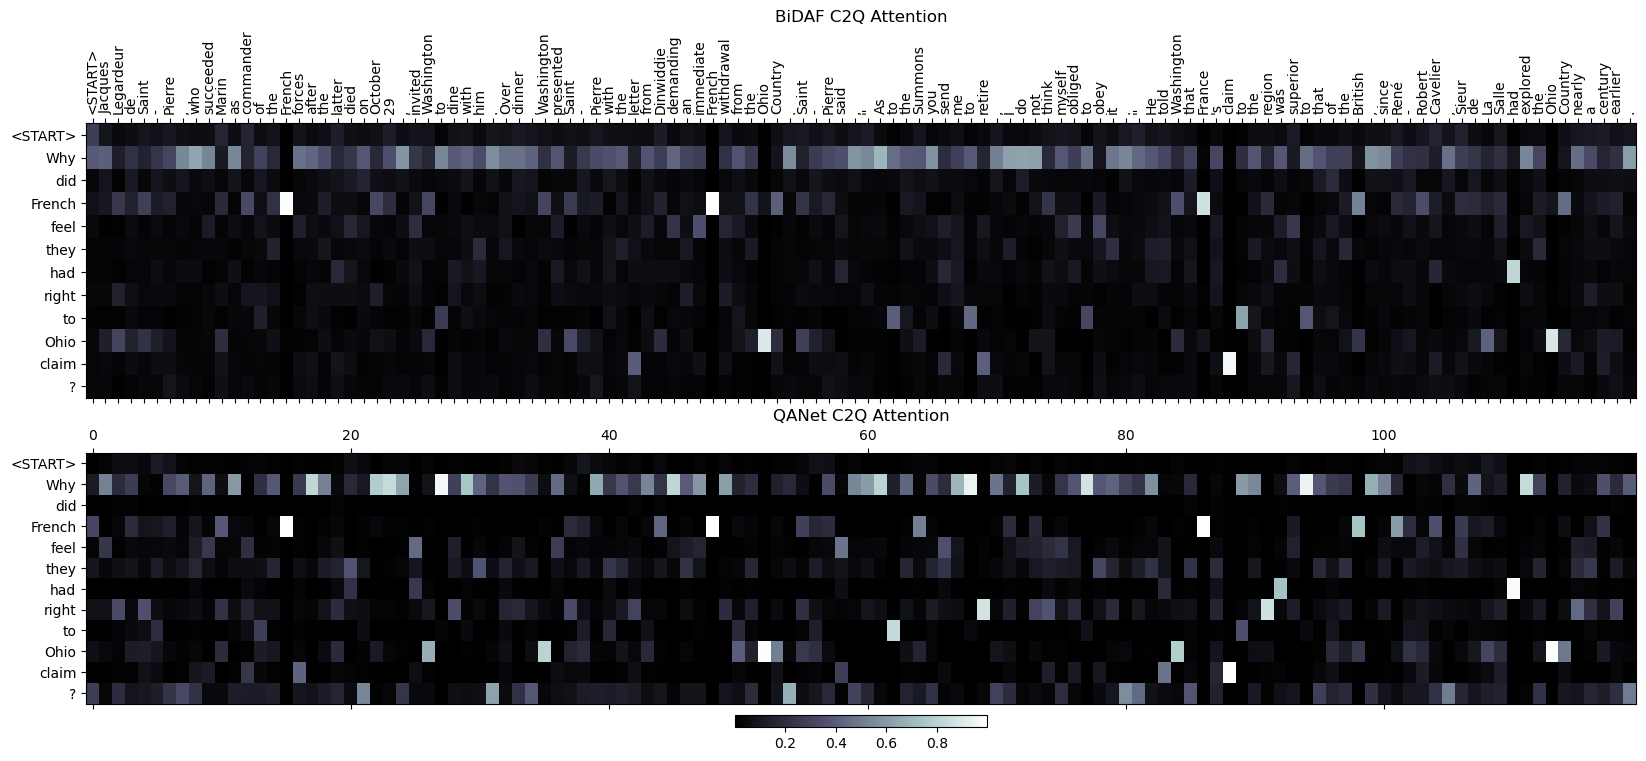

In [303]:
save_file_path = 'attention_q3'
show_attention(bidaf_c2q_attention, qanet_c2q_attention, save_file_path)

In [304]:
print(qanet_c2q_attention.shape, qanet_q2c_attention.shape)

torch.Size([120, 12]) torch.Size([120, 12])


C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1629995797.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1629995797.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '<START>'] + context_words +
C:\Users\jerry\AppData\Local\Temp\ipykernel_9896\1629995797.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '<START>'] + question_words +


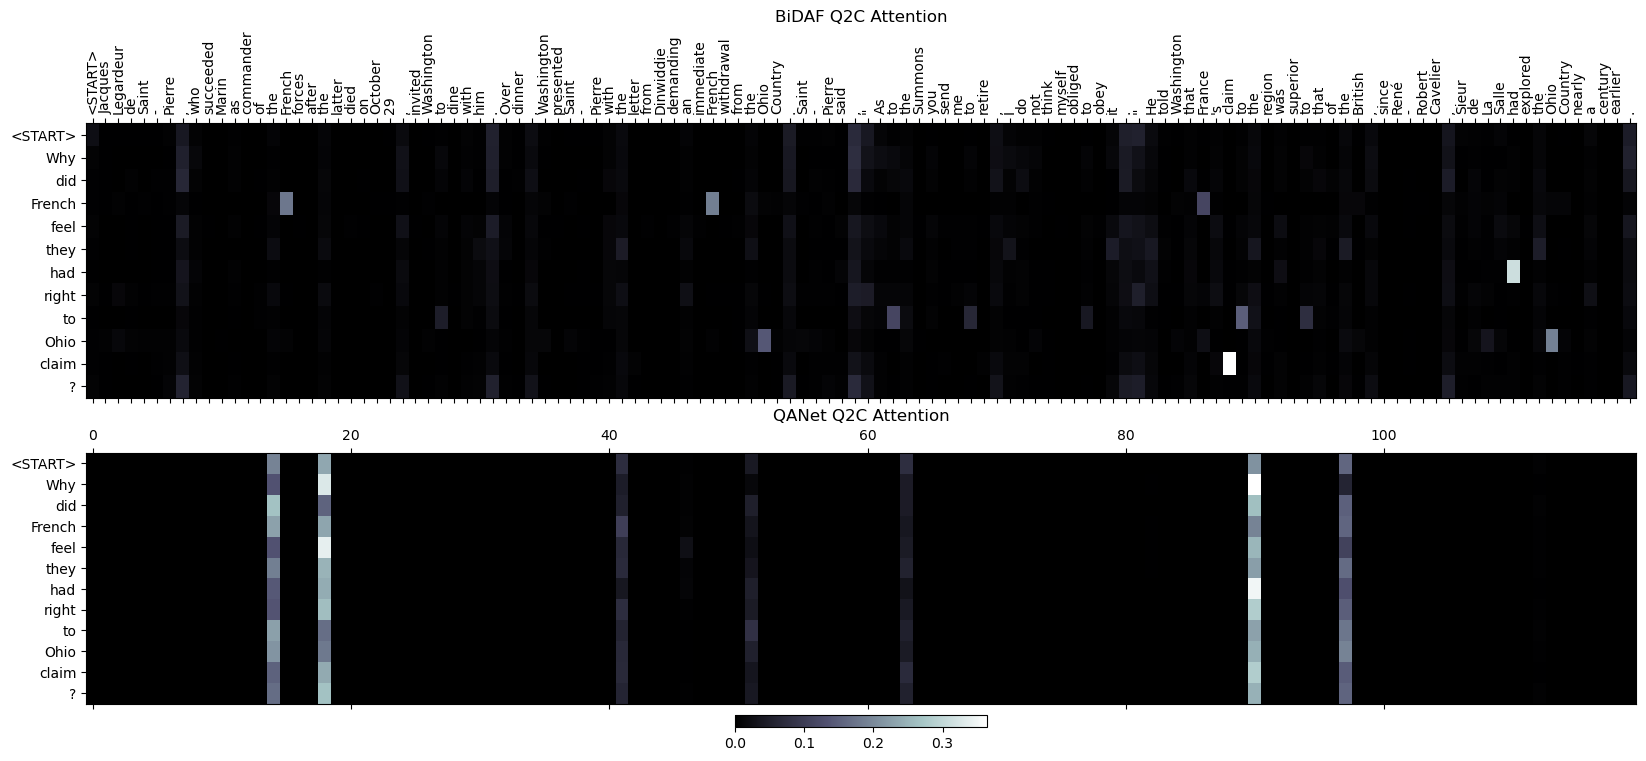

In [306]:
save_file_path = 'q2c_attention_q3'
show_attention(bidaf_q2c_attention, qanet_q2c_attention, save_file_path, c2q=False)